## how often to genes in clusters share funciton?

inspired by https://www.nature.com/articles/s41467-021-25129-x, "The molecular basis, genetic control and pleiotropic effects of local gene co-expression", espeically figure 3 and go term enrishment analysis and https://www.nature.com/articles/s42003-022-03831-w "Shared regulation and functional relevance of local gene co-expression revealed by single cell analysis" go term enrichment analysis

* distance in groups vs not X
* paralog frequency X 
* bidirecitonal promotors X
* shared enhancers X 
* shared go term
* same pathway
* same complex 
* inverted/total ctcf motifs between
* hi-c contacts? (from abc data?)
* cross mappability X

I want to make some plots here, and also add all of these annotations to the cluster file. At a later point, perhaps automate the annotation of the clusters file with this information

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import math
import upsetplot as up
import ast
import os
import statsmodels as sm

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from residualize import calculate_residual
from annotate_clusters import *
from notebook_helper_functions import *
from annotate_null_clusters import *

# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

clusters_dir = config['clusters_dir']


# load in the tissue ids 
tissue_ids = load_tissue_ids(config)
my_tissue_id = 'Thyroid'

protien_coding_only = True

## load in data
cluster df, expression df, gencode

In [3]:
cluster_df = pd.read_csv(f'{prefix}/{clusters_dir}/{my_tissue_id}_clusters_annotated.csv', index_col=0)
null_pairs_exclude_clusters = pd.read_csv(f'{prefix}/{clusters_dir}/{my_tissue_id}_null_annotated.csv', index_col=0)
cluster_df.head()

,N_genes,Transcripts,Perc_cor,Mean_cor,Mean_pos_cor,Mean_neg_cor,Chromosome,Tissue,cluster_size,cluster_tss_size,...,has_high_jaccard_weighted,mean_jaccard_unweighted,mean_jaccard_weighted,interval,num_ctcf_peak,has_ctcf_peak,num_ctcf_point,has_ctcf_point,has_neg_corr,has_high_pos_corr
0,12,"ENSG00000143520.6,ENSG00000143536.7,ENSG000001...",0.712121,0.345263,0.412697,-0.081818,1,Thyroid,757449,746178,...,False,0.066279,0.006948,"(36140330.0, 36267530.0]",5.0,True,5.0,True,True,False
2,4,"ENSG00000117586.10,ENSG00000117592.8,ENSG00000...",0.833333,0.291948,0.291948,NaN,1,Thyroid,486128,462549,...,False,0.000000,0.000000,"(24952730.0, 25231869.0]",9.0,True,9.0,True,False,False
3,4,"ENSG00000069275.12,ENSG00000117280.12,ENSG0000...",0.833333,-0.060394,0.297935,-0.239558,1,Thyroid,137313,99856,...,True,0.544155,0.148282,"(50445091.0, 50490648.0]",2.0,True,2.0,True,True,False
1,4,"ENSG00000058799.14,ENSG00000211452.10,ENSG0000...",0.833333,0.346036,0.346036,NaN,1,Thyroid,116449,56243,...,False,0.000000,0.000000,"(23894004.0, 23972532.0]",4.0,True,4.0,True,False,False
11,3,"ENSG00000137944.17,ENSG00000213516.9,ENSG00000...",1.000000,0.266662,0.266662,NaN,1,Thyroid,87121,34539,...,False,0.000000,0.000000,"(24417879.0, 24528390.0]",4.0,True,4.0,True,False,False


In [4]:
# load in annotated clusters for each tissue
annotated_clusters = {}
annotated_nulls = {}
for tissue_id in tissue_ids:
    annotated_clusters[tissue_id] = pd.read_csv(f'{prefix}/{clusters_dir}/{tissue_id}_clusters_annotated.csv', index_col=0)
    annotated_nulls[tissue_id] = pd.read_csv(f'{prefix}/{clusters_dir}/{tissue_id}_null_annotated.csv', index_col=0)


In [5]:
annotated_clusters

{'Adipose_Subcutaneous':     N_genes                                        Transcripts  Perc_cor  \
 0         9  ENSG00000203786.6,ENSG00000197084.5,ENSG000001...  0.722222   
 1         5  ENSG00000168765.16,ENSG00000213366.12,ENSG0000...  1.000000   
 2         4  ENSG00000121310.16,ENSG00000116171.17,ENSG0000...  0.833333   
 3         4  ENSG00000117228.9,ENSG00000162645.12,ENSG00000...  0.833333   
 4         4  ENSG00000162687.16,ENSG00000000971.15,ENSG0000...  1.000000   
 ..      ...                                                ...       ...   
 5         2               ENSG00000184058.12,ENSG00000215012.8  1.000000   
 4         2              ENSG00000183628.12,ENSG00000100033.16  1.000000   
 3         2               ENSG00000183785.14,ENSG00000184979.9  1.000000   
 2         2              ENSG00000099968.17,ENSG00000015475.18  1.000000   
 22        2               ENSG00000251322.7,ENSG00000100312.10  1.000000   
 
     Mean_cor  Mean_pos_cor  Mean_neg_cor  Chromos

## annotation functions for clusters

are now in annotate_clusters.py

#### plot overlap between categories in the clusters

In [30]:
def generate_bool_indexed(cluster_df, column_list):
    upset_cluster_df = cluster_df.set_index(column_list[0])
    for column_name in column_list[1:]:
        upset_cluster_df.set_index(column_name, append=True, inplace=True)
    return upset_cluster_df

In [31]:
def get_deviation(cluster_df, column_list, type='count'):
    bool_indexed_clusters = generate_bool_indexed(cluster_df,column_list)
    f_observed = up.query(bool_indexed_clusters).subset_sizes

    category_totals = up.query(bool_indexed_clusters).category_totals
    inverse_category_totals = len(cluster_df) - category_totals

    f_expected = f_observed.copy()

    for idx, row in pd.DataFrame(f_expected).iterrows():
        # select the marginal totals corresponding to this index
        values_from_true_index = category_totals[list(idx)].values
        values_from_false_index = inverse_category_totals[[not i for i in idx]].values
        marginal_values = np.concatenate([values_from_false_index, values_from_true_index])
        marginal_percents = marginal_values/len(cluster_df)
        # set the value
        f_expected.loc[idx] = np.prod(marginal_percents) * len(cluster_df)

    # could do this as percent, but that emphasizs small cats
    if type=='percent':
        return (f_observed - f_expected) / f_expected * 100 
    elif type=='count':
        return (f_observed - f_expected)

In [32]:
def plot_upset_binary_categories(cluster_df, column_list, min_subset_size=5, plot_deviation=True):
    bool_indexed_clusters = generate_bool_indexed(cluster_df, column_list)
    deviation = get_deviation(cluster_df, column_list)

    bool_indexed_with_deviation = bool_indexed_clusters.join(deviation.rename('deviation'))
    
    fig = plt.figure(figsize=(8, 5))
    upset = up.UpSet(bool_indexed_with_deviation, show_counts=True, min_subset_size=min_subset_size, sort_by='cardinality')
    if plot_deviation:
        upset.add_catplot(kind='bar', value='deviation', width=.6, color='k')
    upset.plot(fig=fig)


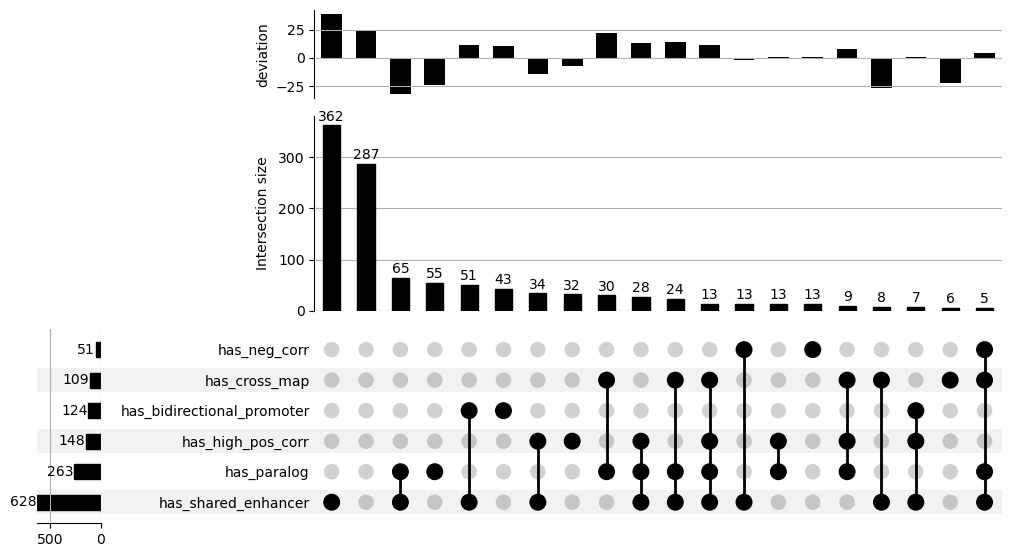

In [33]:
plot_upset_binary_categories(cluster_df, ['has_bidirectional_promoter', 'has_shared_enhancer', 'has_paralog', 'has_cross_map', 'has_neg_corr', 'has_high_pos_corr'])

## plotting functions

#### look at distributions of varis in cluster vs null df 

In [34]:
joined_df = pd.concat([cluster_df[cluster_df['N_genes']==2], null_pairs_exclude_clusters], keys=['cluster', 'null'], names=['type', 'idx'])

<AxesSubplot: xlabel='num_shared_go_any', ylabel='Density'>

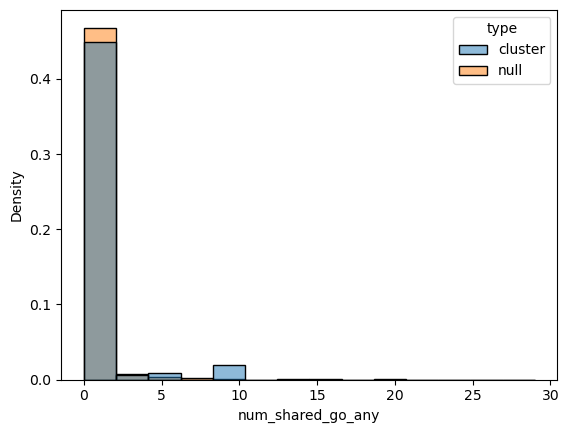

In [36]:
sns.histplot(data=joined_df, hue='type', x='num_shared_go_any', stat='density', common_norm=False)

<AxesSubplot: xlabel='num_ctcf_peak', ylabel='Density'>

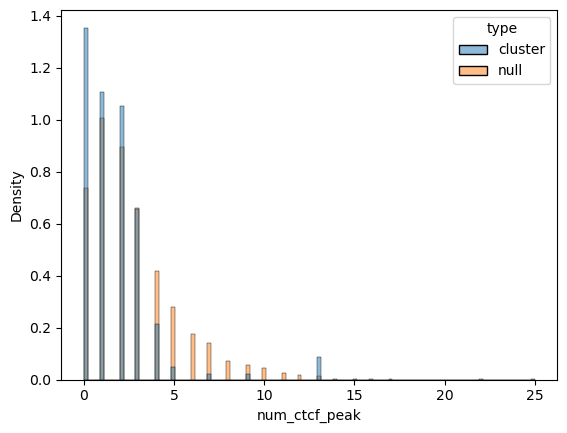

In [37]:
sns.histplot(data=joined_df, hue='type', x='num_ctcf_peak', stat='density', common_norm=False)

<AxesSubplot: xlabel='max_jaccard_unweighted', ylabel='Density'>

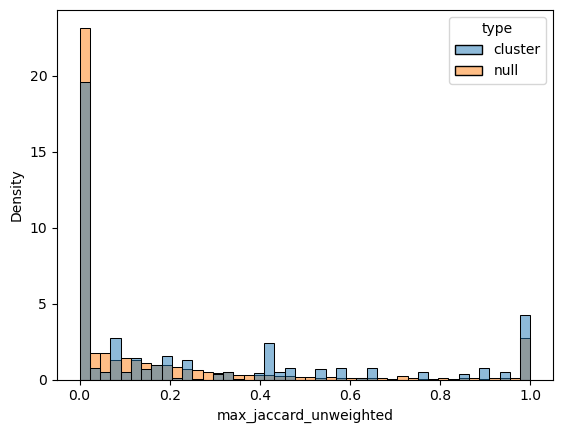

In [38]:
sns.histplot(data=joined_df[~joined_df['max_jaccard_unweighted'].isna()], hue='type', x='max_jaccard_unweighted', stat='density', common_norm=False)

<AxesSubplot: xlabel='max_jaccard_unweighted', ylabel='Density'>

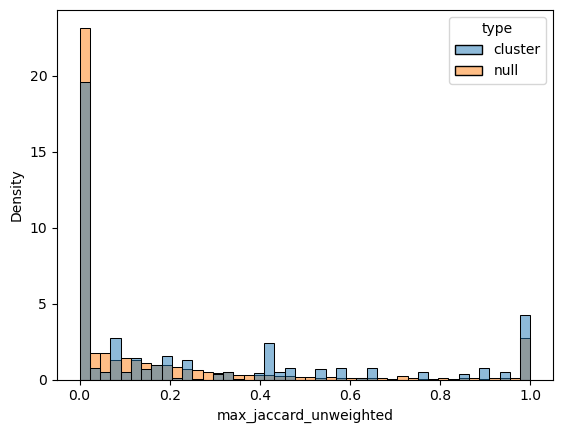

In [39]:
sns.histplot(data=joined_df[~joined_df['max_jaccard_unweighted'].isna()], hue='type', x='max_jaccard_unweighted', stat='density', common_norm=False)

<AxesSubplot: xlabel='max_jaccard_weighted', ylabel='Density'>

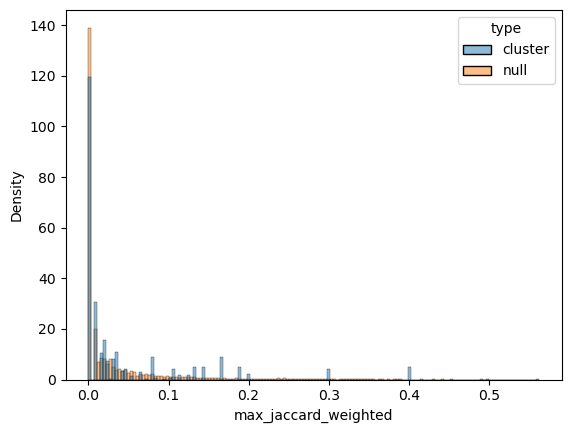

In [40]:
sns.histplot(data=joined_df[~joined_df['max_jaccard_weighted'].isna()], hue='type', x='max_jaccard_weighted', stat='density', common_norm=False)

<AxesSubplot: xlabel='num_strong_enhancers', ylabel='Density'>

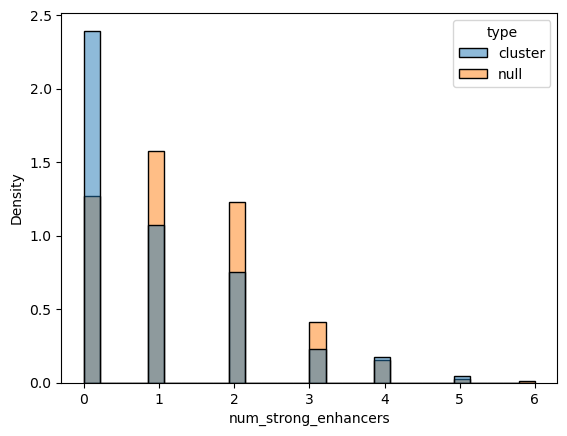

In [41]:
sns.histplot(data=joined_df, hue='type', x='num_strong_enhancers', stat='density', common_norm=False)

<AxesSubplot: xlabel='num_enhancers', ylabel='Density'>

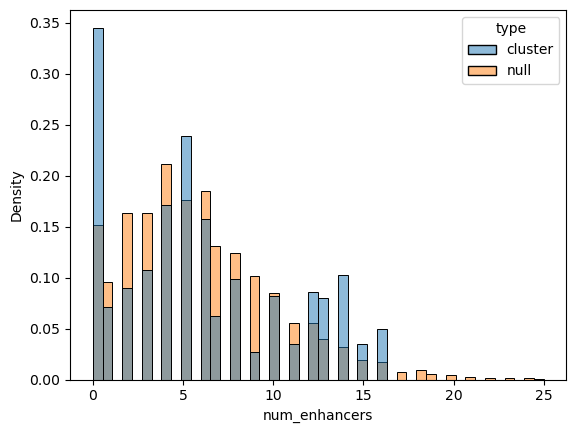

In [42]:
sns.histplot(data=joined_df, hue='type', x='num_enhancers', stat='density', common_norm=False)

<AxesSubplot: xlabel='num_shared_enhancers', ylabel='Density'>

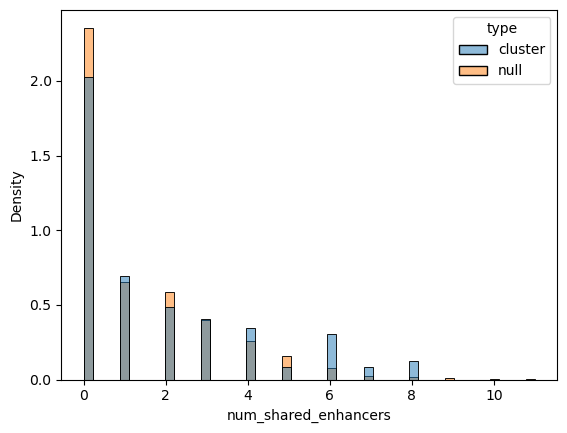

In [43]:
sns.histplot(data=joined_df, hue='type', x='num_shared_enhancers', stat='density', common_norm=False)

<AxesSubplot: xlabel='cluster_size', ylabel='Density'>

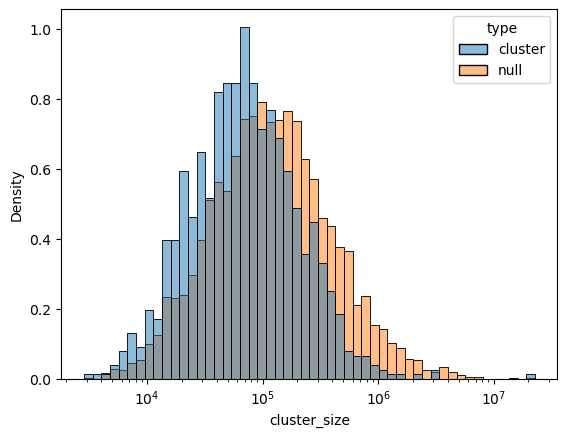

In [44]:
sns.histplot(data=joined_df, hue='type', x='cluster_size', stat='density', log_scale=True, common_norm=False)

<AxesSubplot: xlabel='cluster_tss_size', ylabel='Density'>

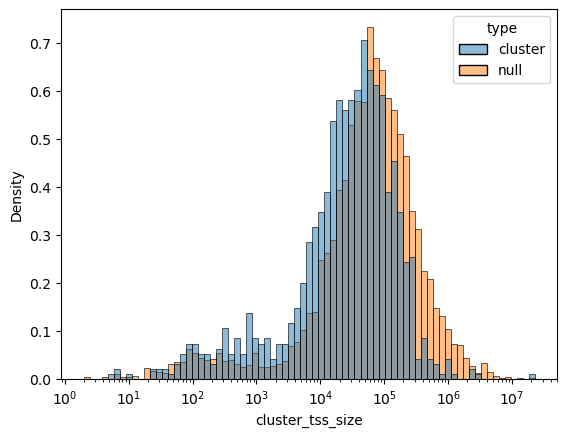

In [45]:
sns.histplot(data=joined_df, hue='type', x='cluster_tss_size', stat='density', log_scale=True, common_norm=False)

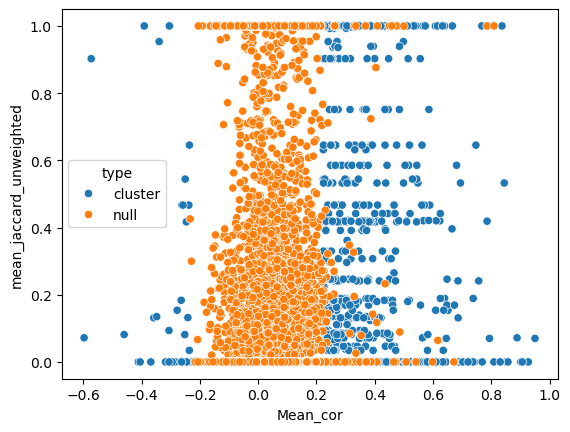

PearsonRResult(statistic=0.12612136360836063, pvalue=9.97847153978445e-23)

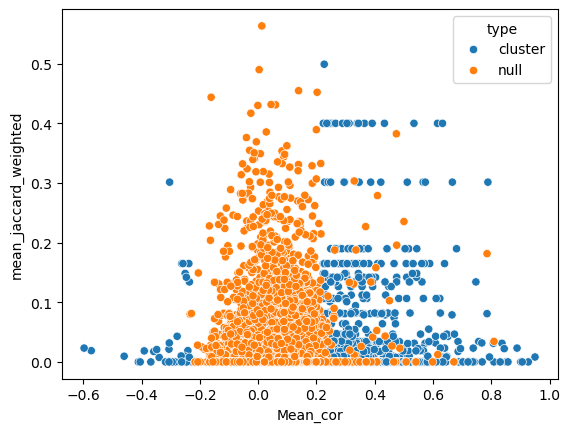

In [48]:
sns.scatterplot(joined_df[~joined_df['mean_jaccard_unweighted'].isna()], x='Mean_cor', y='mean_jaccard_unweighted', hue='type')
plt.show()
sns.scatterplot(joined_df[~joined_df['mean_jaccard_weighted'].isna()], x='Mean_cor', y='mean_jaccard_weighted', hue='type')

stats.pearsonr(joined_df[~joined_df['mean_jaccard_unweighted'].isna()]['mean_jaccard_unweighted'], joined_df[~joined_df['mean_jaccard_unweighted'].isna()]['Mean_cor'])

### log odds

In [5]:
# plot odds ratios

def get_odds_ratio(contingency_table, verb=0):
    # One-sided Fisher's exact test
    odds_ratio, p_value = stats.fisher_exact(contingency_table)
    if verb > 0:
        print("Odds Ratio:", odds_ratio)
        print("P-value:", p_value)

    # Compute 95% confidence interval for odds ratio
    a, b, c, d = contingency_table.flatten()
    SE = np.sqrt(1/a + 1/b + 1/c + 1/d)
    if odds_ratio==0:
        lcb=0
        ucb=0
    else:
        lcb = math.exp(math.log(odds_ratio) - 1.96*SE)  # lower confidence bound
        ucb = math.exp(math.log(odds_ratio) + 1.96*SE)  # upper confidence bound
    if verb > 0:
        print(f"CI: [{lcb}, {ucb}]")

    return p_value, odds_ratio, lcb, ucb

def get_contingency_table(cluster_df, null_df, column_name):
    num_cluster = sum(cluster_df[column_name])
    num_null = sum(null_df[column_name])
    # Build contingency table
    # [[yes clusters, no clusters] [yes null, no null]]
    contingency_table = np.array([[num_cluster, len(cluster_df)-num_cluster],[num_null, len(null_df)-num_null]])
    return contingency_table

def get_log_odds(cluster_df, null_df, column_list):
    log_odds_df = []
    for column_name in column_list:
        p_value, odds_ratio, lcb, ucb = get_odds_ratio(get_contingency_table(cluster_df, null_df, column_name))
        log_odds_df.append(pd.Series({'p_value': p_value,
                'odds_ratio':odds_ratio,
                'lower_cb':lcb,
                'upper_cb':ucb,
                'lower_cb_diff': odds_ratio - lcb,
                'upper_cb_diff': ucb - odds_ratio,
                'col':column_name}))
    return pd.DataFrame(log_odds_df)


# percent belonging to category
def get_frac(column_name, df):
    return sum(df[column_name])/len(df)

In [36]:
def plot_log_odds(cluster_df, null_df, column_list):
    log_odds_df = get_log_odds(cluster_df,null_df, column_list)
    log_odds_df['frac_cluster'] = log_odds_df['col'].apply(get_frac, args=(cluster_df,))
    log_odds_df['frac_null'] = log_odds_df['col'].apply(get_frac, args=(null_df,))
    make_log_odds_frac_plot(log_odds_df)

def make_log_odds_frac_plot(log_odds_df):
    fig, axes = plt.subplots(1, 2, figsize=(12,9))
    make_log_odds_plot(log_odds_df, ax=axes[0])
    make_fraction_plot(log_odds_df, ax=axes[1])
    axes[0].set_ylim(axes[1].get_ylim())
    return axes


def make_log_odds_plot(log_odds_df, ax=None):
    log_odds_df = log_odds_df.reset_index()
    if ax==None:
        fig, ax = plt.subplots(1, figsize=(9,9))

    # log odds plot
    ax.errorbar(y=log_odds_df['col'], x=log_odds_df['odds_ratio'], xerr=log_odds_df[['lower_cb_diff', 'upper_cb_diff']].values.transpose(), fmt="o")
    ax.axvline(1, color='k', linestyle='--')
    ax.set_xlabel('Log odds')

    for idx,row in log_odds_df.iterrows():
        ax.annotate('OR = {:.2f}, p={:.1E}'.format(row['odds_ratio'], row['p_value']), (row['odds_ratio'], idx+.15))
        #axes[0].annotate('log odds={:.1f}'.format(np.log(row['odds_ratio'])), (row['odds_ratio'], idx-.3))
    ax.set_xscale(u'log')
    return ax


def make_fraction_plot(log_odds_df, ax=None):
    if ax==None:
        fig, ax = plt.subplots(1, figsize=(9,9))
    # fraction plot
    sns.barplot(data=log_odds_df, x='frac_cluster', y='col', ax=ax)
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('Fraction in category')

    # make the labels match in order and position
    ax.invert_yaxis()
    return ax

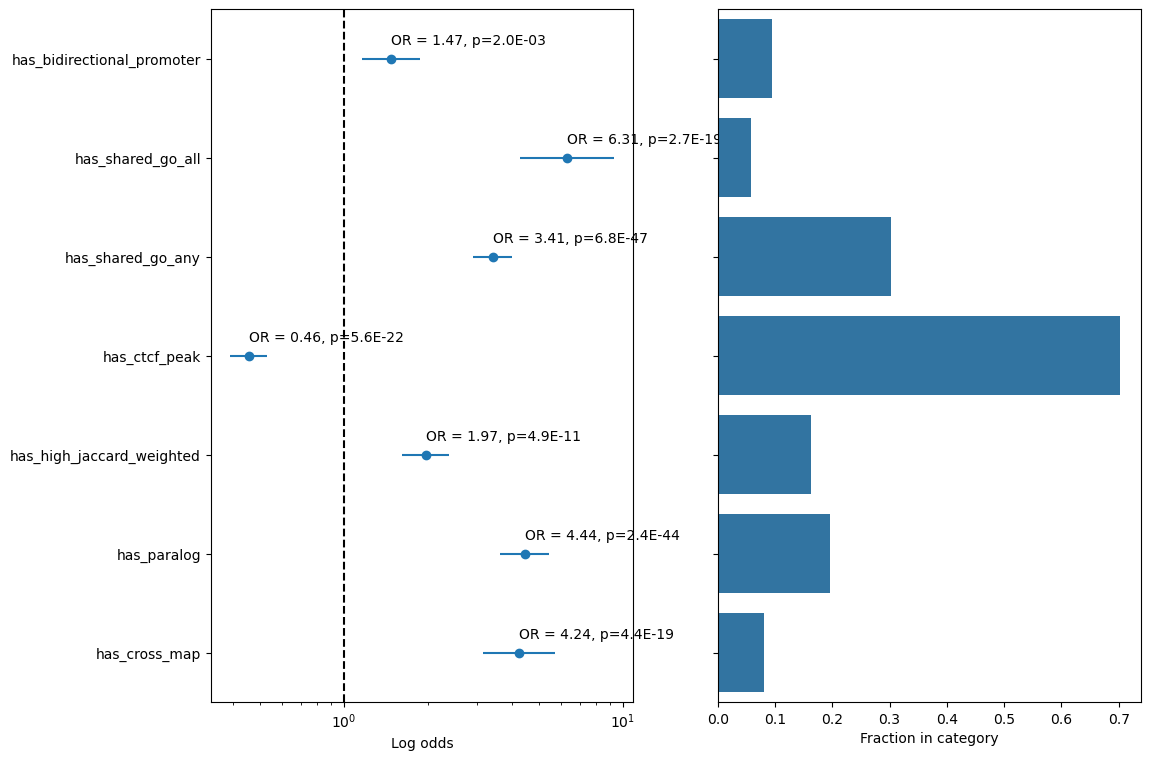

In [7]:
plot_log_odds(cluster_df[cluster_df['N_genes']==2], null_pairs_exclude_clusters, ['has_cross_map',
                                                                        'has_paralog', 
                                                                        #'has_high_jaccard_unweighted', 
                                                                        'has_high_jaccard_weighted', 
                                                                        #'has_shared_enhancer', 
                                                                        'has_ctcf_peak',
                                                                        #'has_complexes', 
                                                                        'has_shared_go_any', 
                                                                        'has_shared_go_all', 
                                                                        'has_bidirectional_promoter'])

/local/scratch/klawren/slrmtmp.44050099/ipykernel_19685/3080165456.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  SE = np.sqrt(1/a + 1/b + 1/c + 1/d)


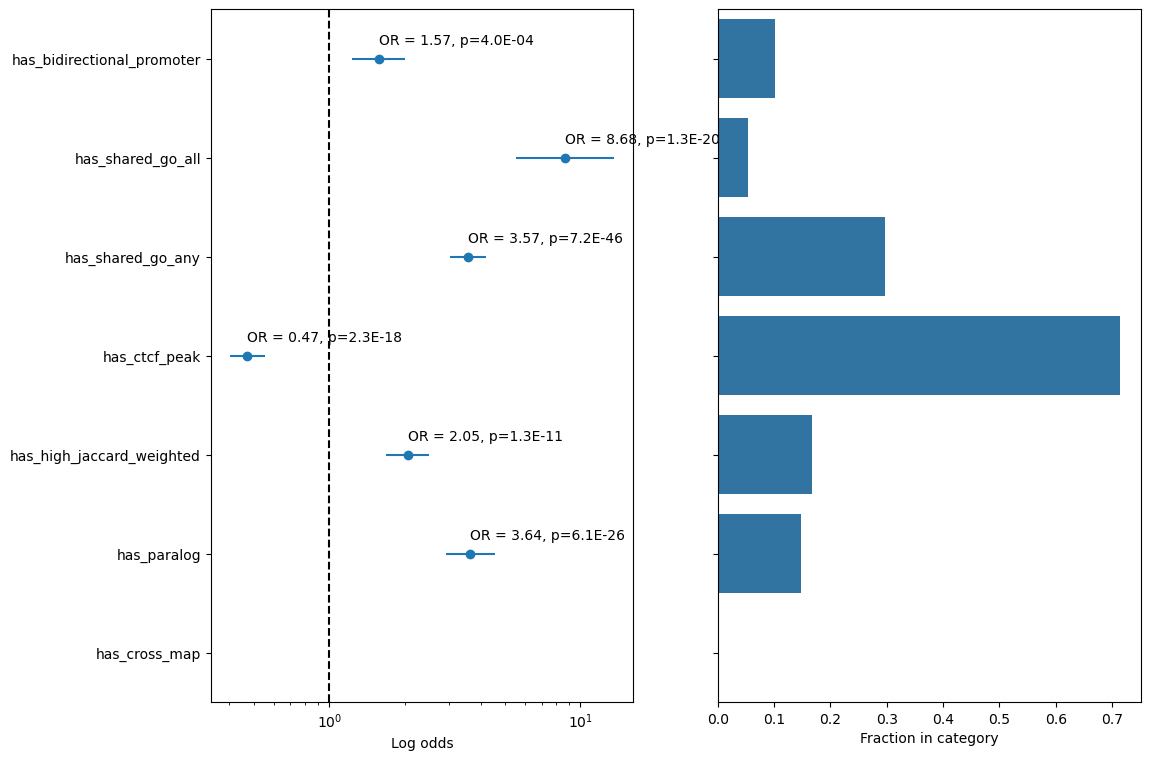

In [8]:
axes = plot_log_odds(cluster_df[(cluster_df['N_genes']==2)&(cluster_df['has_cross_map']==False)], null_pairs_exclude_clusters[null_pairs_exclude_clusters['has_cross_map']==False], ['has_cross_map',
                                                                        'has_paralog', 
                                                                        #'has_high_jaccard_unweighted', 
                                                                        'has_high_jaccard_weighted', 
                                                                        #'has_shared_enhancer', 
                                                                        'has_ctcf_peak',
                                                                        #'has_complexes', 
                                                                        'has_shared_go_any', 
                                                                        'has_shared_go_all', 
                                                                        'has_bidirectional_promoter'])
#axes[0].set_title('Excluding cross mappable genes')

In [ ]:
axes = plot_log_odds(cluster_df[cluster_df['N_genes']==2], null_pairs_genome_dist_matched, ['has_bidirectional_promoter', 'has_shared_enhancer', 'has_shared_strong_enhancer', 'has_shared_very_strong_enhancer', 'has_paralog', 'has_cross_map', 'has_shared_go_any', 'has_shared_go_all'])
axes[0].set_title('Distance matched')

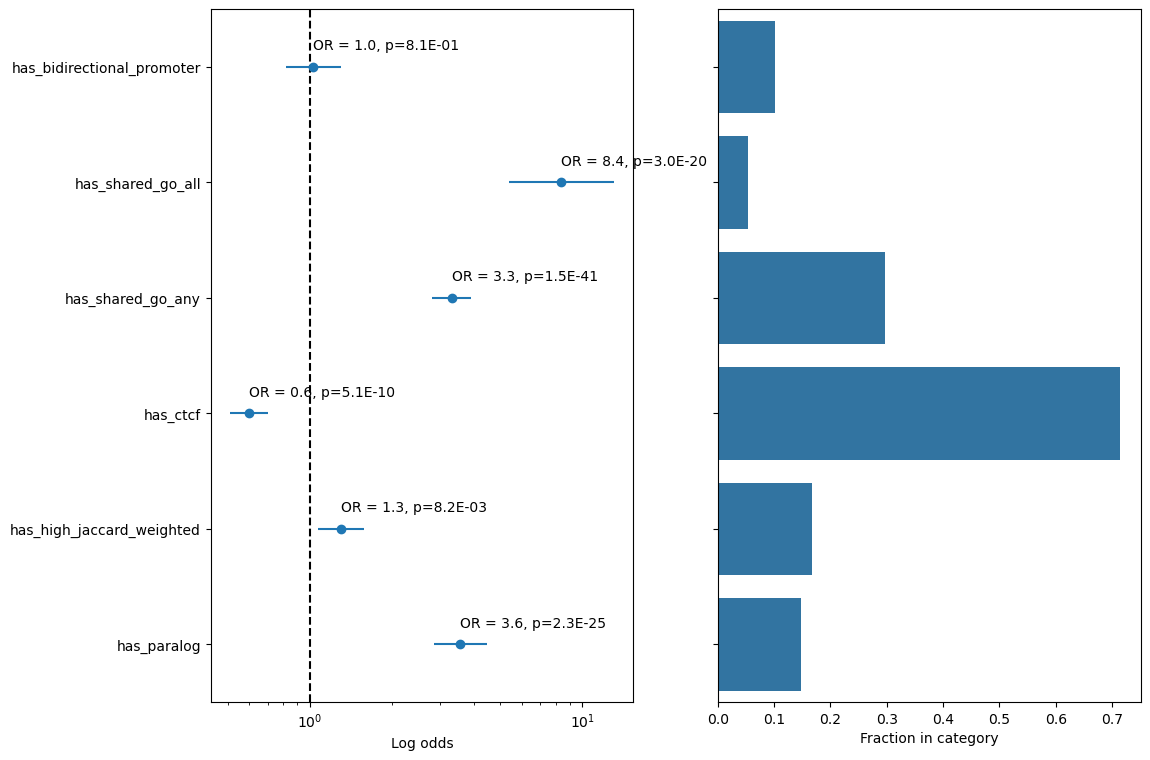

In [242]:
axes = plot_log_odds(cluster_df[(cluster_df['N_genes']==2)&(cluster_df['has_cross_map']==False)], null_pairs_genome_dist_matched[(null_pairs_genome_dist_matched['has_cross_map']==False)], [
                                                                        #'has_cross_map',
                                                                        'has_paralog', 
                                                                        #'has_high_jaccard_unweighted', 
                                                                        'has_high_jaccard_weighted', 
                                                                        #'has_shared_enhancer', 
                                                                        'has_ctcf',
                                                                        #'has_complexes', 
                                                                        'has_shared_go_any', 
                                                                        'has_shared_go_all', 
                                                                        'has_bidirectional_promoter'])
#axes[0].set_title('Distance matched, excluding cross mapped')

#### plot for continuous vars

using the number of things for the continuous variables
* num_ctcf_peak
* mean_jaccard_weighted
* log cluster_tss_size
* num_shared_go_any


binary vars (for pairs)
* num_cross_map
* num_paralog
* num_bidirectional_promoter
* num_shared_go_all

In [7]:
import statsmodels.api as sm

In [8]:
# add log size (for size corrections)
cluster_df['log_size'] = np.log10(cluster_df['cluster_tss_size'])
null_pairs_exclude_clusters['log_size'] = np.log10(null_pairs_exclude_clusters['cluster_tss_size'])


# balanced classes? not sure if this matters
#joined_df = pd.concat([cluster_df[cluster_df['N_genes']==2], null_pairs_exclude_clusters.sample(sum(cluster_df['N_genes']==2))], keys=['cluster', 'null'], names=['type', 'idx'])
joined_df = pd.concat([cluster_df[cluster_df['N_genes']==2], null_pairs_exclude_clusters], keys=['cluster', 'null'], names=['type', 'idx'])

joined_no_crossmap_df = joined_df[~joined_df['has_cross_map']]

In [9]:
# fit a logit model

def fit_logistic_model(joined_df, column, correct_size=False, filter_on_column=None, verb=True):
    if verb:
        print(column)
    try:
        final_joined_df = joined_df[joined_df[filter_on_column]!=0]
    except KeyError:
        final_joined_df = joined_df

    if correct_size:
        x = final_joined_df[['log_size', column]]
    else:
        x = final_joined_df[column]

    y = final_joined_df.reset_index()['type'].values == 'cluster'
    x_with_constant = sm.add_constant(x) # Add intercept term

    logit_model = sm.Logit(y, x_with_constant)
    try:
        result = logit_model.fit()
    except np.linalg.LinAlgError:
        print(joined_df.head())
        print(column)
        sns.histplot(joined_df[column])
        raise np.linalg.LinAlgError
    if verb:
        print(result.summary())

    coefficients = result.params
    conf_int = result.conf_int()
    odds_ratios = np.exp(coefficients)
    odds_ratios_ci = np.exp(conf_int)

    odds_ratios_ci.rename(columns={0:'lower_cb', 1:'upper_cb'}, inplace=True)
    odds_ratios_ci['odds_ratio'] = odds_ratios
    odds_ratios_ci['p_value'] = result.pvalues
    odds_ratios_ci['col'] = column
    odds_ratios_ci['lower_cb_diff'] = odds_ratios_ci['odds_ratio'] - odds_ratios_ci['lower_cb']
    odds_ratios_ci['upper_cb_diff'] = odds_ratios_ci['upper_cb'] - odds_ratios_ci['odds_ratio']
    
    return odds_ratios_ci.loc[column]


def get_odds_df(joined_df, verb=True, correct_size=False, column_list = ['num_bidirectional_promoter', 'num_shared_enhancers',
       'num_shared_strong_enhancers', 'num_enhancers', 'num_strong_enhancers',
       'num_paralog', 'num_shared_go_all', 'num_shared_go_any',
       'num_ctcf_peak', 'num_ctcf_point', 'log_size', 'max_jaccard_unweighted', 'max_jaccard_weighted'], 
       filter_list=['max_jaccard_unweighted', 'max_jaccard_weighted']):
       column_list = pd.Series(column_list)
       odds_ratios_no_filter = pd.DataFrame([fit_logistic_model(joined_df, c, verb=verb, correct_size=correct_size) for c in column_list[~column_list.isin(filter_list)]]) 
       odds_ratios_filtered = pd.DataFrame([fit_logistic_model(joined_df, c, filter_on_column='num_enhancers', verb=verb, correct_size=correct_size) for c in column_list[column_list.isin(filter_list)]]) 
       return pd.concat([odds_ratios_no_filter, odds_ratios_filtered])

In [10]:
# log odds plot with multiple odds per category 
def make_log_odds_plot_multiple(odds_ratios_list, ax=None, labels=None, add_annotations=True, offset = 0.2):
    
    if ax==None:
        fig, ax = plt.subplots(1, figsize=(9,9))

    colors = sns.color_palette()  # add more colors if needed
    
    for idx, odds_ratio_df in enumerate(odds_ratios_list):
        odds_ratio_df = odds_ratio_df.reindex(odds_ratios_list[0].index).reset_index()
        color = colors[idx % len(colors)]  # cycle through colors if more than available
        ax.errorbar(y=odds_ratio_df.reset_index().index.values + idx*offset, x=odds_ratio_df['odds_ratio'], 
                    xerr=odds_ratio_df[['lower_cb_diff', 'upper_cb_diff']].values.transpose(), fmt="o", 
                    color=color, label=labels[idx] if labels else None, markersize=3)
        ax.axvline(1, color='k', linestyle='--')

        if add_annotations:
            for row_idx, row in odds_ratio_df.iterrows():
                ax.annotate('OR = {:.2f}, p={:.1E}'.format(row['odds_ratio'], row['p_value']), 
                            (row['odds_ratio'], row_idx + idx*offset + 0.05), fontsize=6)
            
    if labels:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(reversed(handles), reversed(labels))

    ax.set_xscale(u'log')
    ax.set_yticks(ticks=odds_ratio_df.index.values + (len(odds_ratios_list)-1)*offset/2, labels=(odds_ratio_df['col']))
    return ax

### basic model, odds for each param

num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.451325
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6007
Model:                          Logit   Df Residuals:                     6005
Method:                           MLE   Df Model:                            1
Date:                Fri, 16 Aug 2024   Pseudo R-squ.:                0.001759
Time:                        11:38:38   Log-Likelihood:                -2711.1
converged:                       True   LL-Null:                       -2715.9
Covariance Type:            nonrobust   LLR p-value:                  0.001995
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.6335      0.036 

Optimization terminated successfully.
         Current function value: 0.435888
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6007
Model:                          Logit   Df Residuals:                     6005
Method:                           MLE   Df Model:                            1
Date:                Fri, 16 Aug 2024   Pseudo R-squ.:                 0.03590
Time:                        11:38:39   Log-Likelihood:                -2618.4
converged:                       True   LL-Null:                       -2715.9
Covariance Type:            nonrobust   LLR p-value:                 2.556e-44
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.7678      0.038    -46.471      0.000      -1.842      -1.693
num_paralog     0.7458    

<AxesSubplot: xlabel='Log odds'>

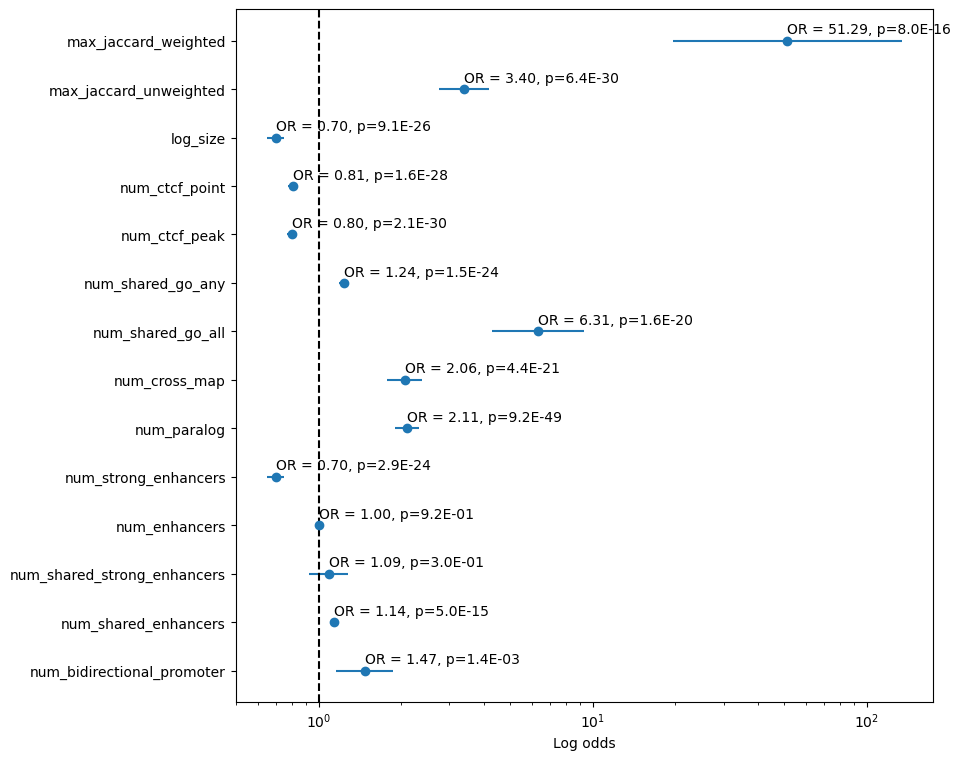

In [14]:
odds_ratios = get_odds_df(joined_df, column_list = ['num_bidirectional_promoter', 'num_shared_enhancers',
       'num_shared_strong_enhancers', 'num_enhancers', 'num_strong_enhancers',
       'num_paralog','num_cross_map', 'num_shared_go_all', 'num_shared_go_any',
       'num_ctcf_peak', 'num_ctcf_point', 'log_size', 'max_jaccard_unweighted', 'max_jaccard_weighted'])
make_log_odds_plot(odds_ratios.reset_index())

num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.436868
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5825
Model:                          Logit   Df Residuals:                     5823
Method:                           MLE   Df Model:                            1
Date:                Fri, 16 Aug 2024   Pseudo R-squ.:                0.002488
Time:                        11:38:43   Log-Likelihood:                -2544.8
converged:                       True   LL-Null:                       -2551.1
Covariance Type:            nonrobust   LLR p-value:                 0.0003667
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.7037      0.038 

<AxesSubplot: >

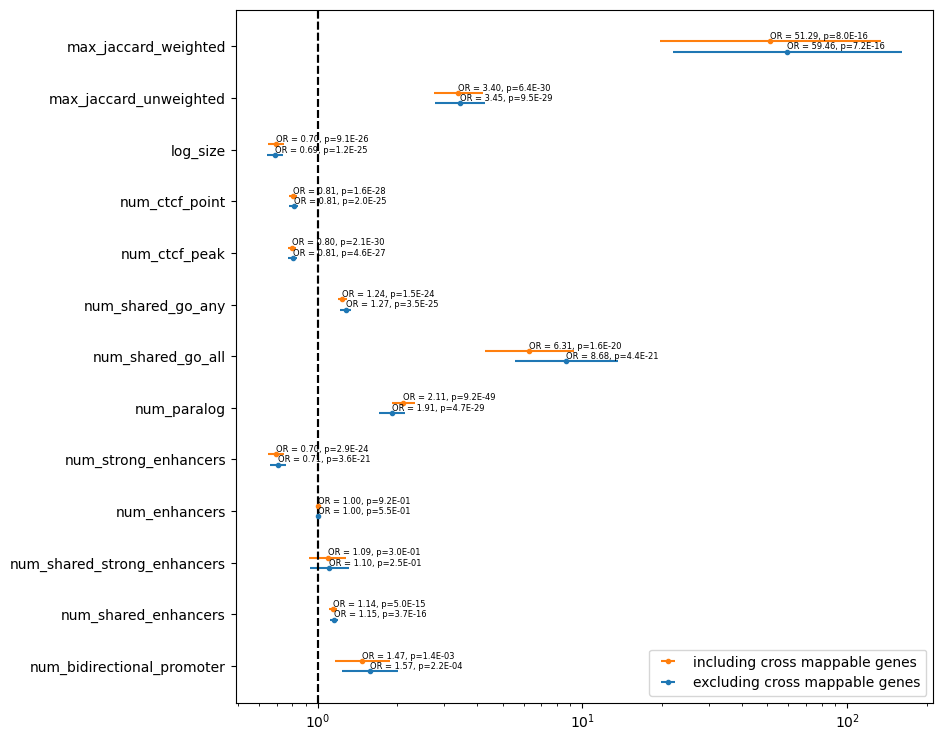

In [15]:
# with and without removing cross mappable (remove for future plots)
odds_ratios_no_cross = get_odds_df(joined_no_crossmap_df)
make_log_odds_plot_multiple([odds_ratios_no_cross, odds_ratios[~(odds_ratios['col'] == 'num_cross_map')]], labels=['excluding cross mappable genes', 'including cross mappable genes'])

### positive vs negative correlation

num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.098674
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4998
Method:                           MLE   Df Model:                            1
Date:                Fri, 16 Aug 2024   Pseudo R-squ.:                0.001445
Time:                        11:38:44   Log-Likelihood:                -493.37
converged:                       True   LL-Null:                       -494.08
Covariance Type:            nonrobust   LLR p-value:                    0.2321
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -3.9166      0.106 

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 4934
Model:                          Logit   Df Residuals:                     4932
Method:                           MLE   Df Model:                            1
Date:                Fri, 16 Aug 2024   Pseudo R-squ.:                 0.02005
Time:                        11:38:46   Log-Likelihood:                -203.90
converged:                       True   LL-Null:                       -208.08
Covariance Type:            nonrobust   LLR p-value:                  0.003871
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9762      0.610     -4.877      0.000      -4.172      -1.780
log_size      -0.4412      0.140     -3.153      0.002      -0.715      -0.167
max_jaccard_unweighted
Optimization terminated succe

<AxesSubplot: >

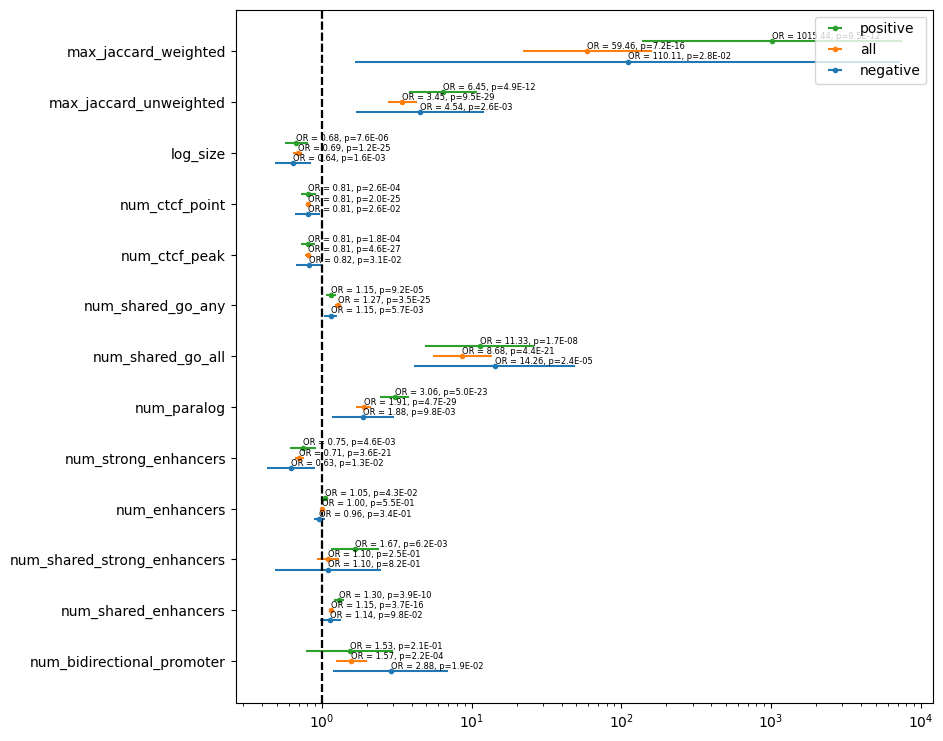

In [16]:
pos_cluster_df = pd.concat([cluster_df[(cluster_df['N_genes']==2) & (cluster_df['has_high_pos_corr'])], null_pairs_exclude_clusters], keys=['cluster', 'null'], names=['type', 'idx'])
pos_cluster_df = pos_cluster_df[~pos_cluster_df['has_cross_map']]
odds_ratios_positive = get_odds_df(pos_cluster_df)

neg_cluster_df = pd.concat([cluster_df[(cluster_df['N_genes']==2) & (cluster_df['has_neg_corr'])], null_pairs_exclude_clusters], keys=['cluster', 'null'], names=['type', 'idx'])
neg_cluster_df = neg_cluster_df[~neg_cluster_df['has_cross_map']]
odds_ratios_negative = get_odds_df(neg_cluster_df)

make_log_odds_plot_multiple([odds_ratios_negative, odds_ratios_no_cross, odds_ratios_positive], labels=['negative', 'all', 'positive'])


#### with and without distance corection

num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.424548
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5825
Model:                          Logit   Df Residuals:                     5822
Method:                           MLE   Df Model:                            2
Date:                Fri, 16 Aug 2024   Pseudo R-squ.:                 0.03062
Time:                        11:38:47   Log-Likelihood:                -2473.0
converged:                       True   LL-Null:                       -2551.1
Covariance Type:            nonrobust   LLR p-value:                 1.190e-34
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          1.6820      0.285 

num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.438694
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5806
Model:                          Logit   Df Residuals:                     5804
Method:                           MLE   Df Model:                            1
Date:                Fri, 16 Aug 2024   Pseudo R-squ.:               0.0002942
Time:                        11:38:50   Log-Likelihood:                -2547.1
converged:                       True   LL-Null:                       -2547.8
Covariance Type:            nonrobust   LLR p-value:                    0.2208
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.6762      0.038 

<AxesSubplot: >

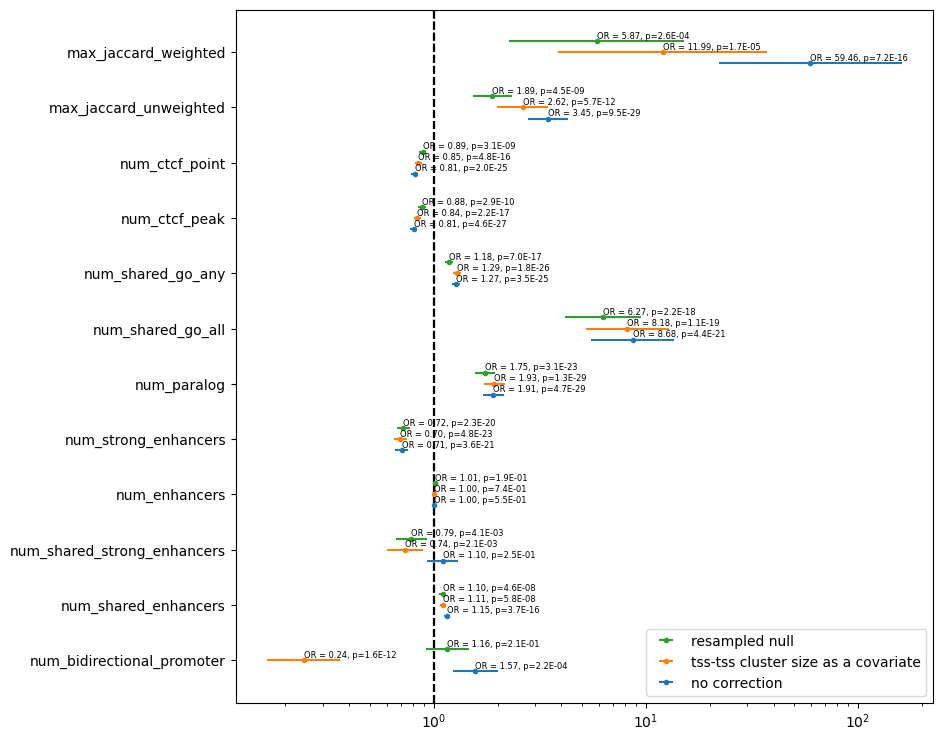

In [17]:
column_list = ['num_bidirectional_promoter', 'num_shared_enhancers',
       'num_shared_strong_enhancers', 'num_enhancers', 'num_strong_enhancers',
       'num_paralog', 'num_shared_go_all', 'num_shared_go_any',
       'num_ctcf_peak', 'num_ctcf_point', 'max_jaccard_unweighted', 'max_jaccard_weighted']

odds_ratios_correct_size = get_odds_df(joined_no_crossmap_df, correct_size=True,  column_list = column_list)
odds_ratios_no_correct_size = get_odds_df(joined_no_crossmap_df, correct_size=False,  column_list = column_list)

# resampled null
distance_matched_null = get_resamp_null_cluster(null_pairs_exclude_clusters, cluster_df)
resamp_joined_df = pd.concat([cluster_df[(cluster_df['N_genes']==2)], distance_matched_null], keys=['cluster', 'null'], names=['type', 'idx'])
resamp_joined_df = resamp_joined_df[~resamp_joined_df['has_cross_map']]
odds_ratios_resamp = get_odds_df(resamp_joined_df, column_list=column_list)

make_log_odds_plot_multiple([odds_ratios_no_correct_size, odds_ratios_correct_size, odds_ratios_resamp], labels=['no correction', 'tss-tss cluster size as a covariate', 'resampled null'])

## combining over all tissues

# only combine over tissues with a gtex match
GTEX_tissue,ABC_biosample_id
Adipose_Subcutaneous,adipose_tissue-ENCODE
Adipose_Visceral_Omentum,None
Artery_Tibial,coronary_artery-ENCODE
Cells_Cultured_fibroblasts,fibroblast_of_arm-ENCODE
Esophagus_Mucosa,None
Esophagus_Muscularis,None
Lung,fibroblast_of_lung-Roadmap
Muscle_Skeletal,gastrocnemius_medialis-ENCODE
Nerve_Tibial,None
Skin_Not_Sun_Exposed_Suprapubic,foreskin_fibroblast-Roadmap
Skin_Sun_Exposed_Lower_leg,fibroblast_of_dermis-Roadmap
Thyroid,thyroid_gland-ENCODE
Whole_Blood,Bcells

Adipose_Subcutaneous, Artery_Tibial, Cells_Cultured_fibroblasts, Lung, Muscle_Skeletal, Skin_Not_Sun_Exposed_Suprapubic, Skin_Sun_Exposed_Lower_leg, Thyroid, Whole_Blood

In [18]:
enhancer_tissue_ids = ['Adipose_Subcutaneous', 'Artery_Tibial', 'Cells_Cultured_fibroblasts', 'Lung', 'Muscle_Skeletal', 'Skin_Not_Sun_Exposed_Suprapubic', 'Skin_Sun_Exposed_Lower_leg', 'Thyroid']

In [19]:
combined_clusters = pd.concat([annotated_clusters[t] for t in tissue_ids],  keys=tissue_ids, names=['tissue', '.']).reset_index()
combined_nulls = pd.concat([annotated_nulls[t] for t in tissue_ids], keys=tissue_ids, names=['tissue', '.']).reset_index()

tissue_combined_joined_df = pd.concat([combined_clusters[(combined_clusters['N_genes']==2)], combined_nulls], keys=['cluster', 'null'], names=['type', 'idx'])
tissue_combined_joined_df['log_size'] = np.log10(tissue_combined_joined_df['cluster_tss_size'])
tissue_combined_joined_df = tissue_combined_joined_df[~(tissue_combined_joined_df['has_cross_map'])]

tissue_combined_enhancer_joined_df = tissue_combined_joined_df[tissue_combined_joined_df['tissue'].isin(enhancer_tissue_ids)]

num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.411220
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5714
Model:                          Logit   Df Residuals:                     5712
Method:                           MLE   Df Model:                            1
Date:                Fri, 16 Aug 2024   Pseudo R-squ.:                0.002415
Time:                        11:38:52   Log-Likelihood:                -2349.7
converged:                       True   LL-Null:                       -2355.4
Covariance Type:            nonrobust   LLR p-value:                 0.0007431
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.8188      0.040 

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/ho

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5714
Model:                          Logit   Df Residuals:                     5712
Method:                           MLE   Df Model:                            1
Date:                Fri, 16 Aug 2024   Pseudo R-squ.:                0.003250
Time:                        11:38:52   Log-Likelihood:                -2347.7
converged:                       True   LL-Null:                       -2355.4
Covariance Type:            nonrobust   LLR p-value:                 9.112e-05
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.7721      0.038    -47.001      0.000      -1.846      -1.698
num_ctcf_peak   -37.3923   5.93e+07   -6.3e-07      1.000   -1.16e+08    1.16e+08
num_ctcf_point
         Current function

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5599
Model:                          Logit   Df Residuals:                     5597
Method:                           MLE   Df Model:                            1
Date:                Fri, 16 Aug 2024   Pseudo R-squ.:                 0.01728
Time:                        11:38:54   Log-Likelihood:                -2111.2
converged:                       True   LL-Null:                       -2148.4
Covariance Type:            nonrobust   LLR p-value:                 6.866e-18
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.0078      0.042    -47.280      0.000      -2.091      -1.925
num_paralog     0.6228      0.067      9.305      0.000       0.492       0.754
num_shared_go_all
Optimization terminated succes

(0.001, 1000)

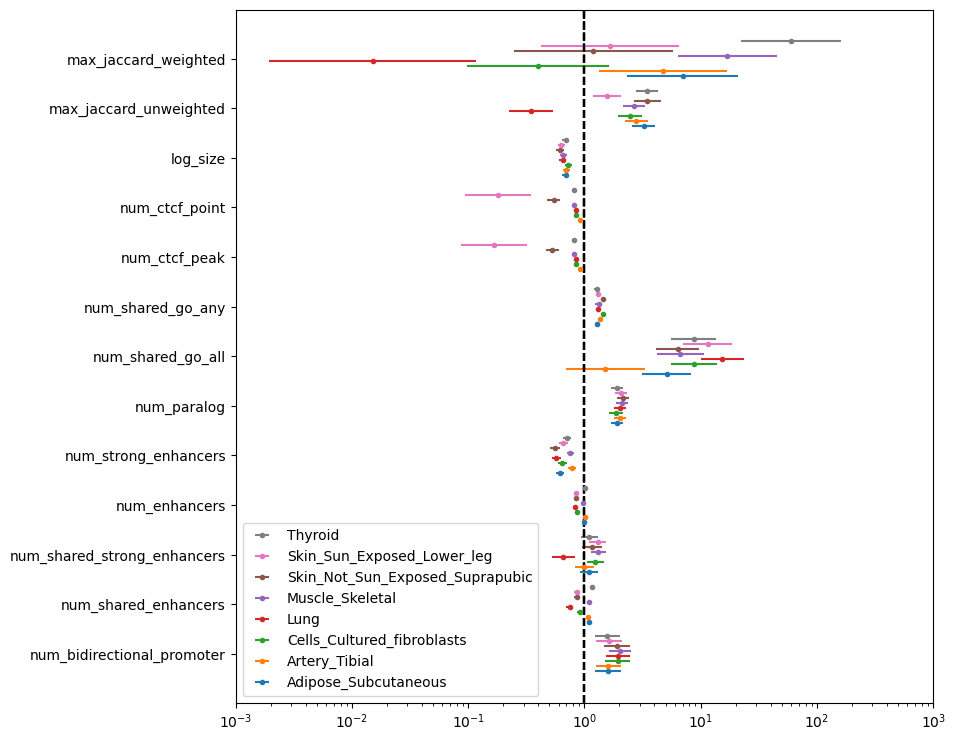

In [20]:
# individual per tissue
odds_ratios = [get_odds_df(tissue_combined_enhancer_joined_df[tissue_combined_enhancer_joined_df['tissue']==t]) for t in enhancer_tissue_ids]
ax = make_log_odds_plot_multiple(odds_ratios, labels=enhancer_tissue_ids, add_annotations=False, offset=.1)
ax.set_xlim(.001, 1000)

num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.403444
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                45469
Model:                          Logit   Df Residuals:                    45467
Method:                           MLE   Df Model:                            1
Date:                Fri, 16 Aug 2024   Pseudo R-squ.:                0.004178
Time:                        11:39:00   Log-Likelihood:                -18344.
converged:                       True   LL-Null:                       -18421.
Covariance Type:            nonrobust   LLR p-value:                 2.417e-35
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.8658      0.014 

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                45469
Model:                          Logit   Df Residuals:                    45467
Method:                           MLE   Df Model:                            1
Date:                Fri, 16 Aug 2024   Pseudo R-squ.:                 0.01476
Time:                        11:39:02   Log-Likelihood:                -18149.
converged:                       True   LL-Null:                       -18421.
Covariance Type:            nonrobust   LLR p-value:                2.816e-120
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.8598      0.014   -134.506      0.000      -1.887      -1.833
num_shared_go_all     2.0269      0.083     24.393      0.000       1.864       2.190
num_shared_go_any
Optimi

<AxesSubplot: >

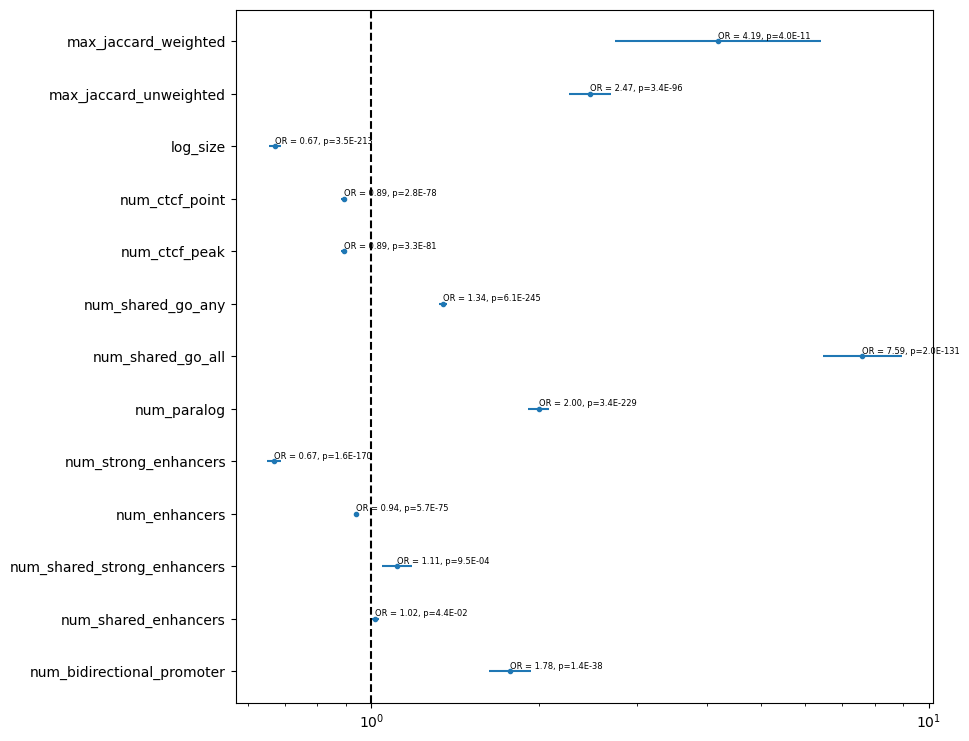

In [21]:
# these look reasonably similar, combine over them
odds_ratios_enhancer = get_odds_df(tissue_combined_enhancer_joined_df)
make_log_odds_plot_multiple([odds_ratios_enhancer])

num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.393379
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                73408
Model:                          Logit   Df Residuals:                    73406
Method:                           MLE   Df Model:                            1
Date:                Fri, 16 Aug 2024   Pseudo R-squ.:                0.003706
Time:                        11:39:05   Log-Likelihood:                -28877.
converged:                       True   LL-Null:                       -28985.
Covariance Type:            nonrobust   LLR p-value:                 1.204e-48
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.9100      0.011 

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                73408
Model:                          Logit   Df Residuals:                    73406
Method:                           MLE   Df Model:                            1
Date:                Fri, 16 Aug 2024   Pseudo R-squ.:                 0.02130
Time:                        11:39:08   Log-Likelihood:                -28367.
converged:                       True   LL-Null:                       -28985.
Covariance Type:            nonrobust   LLR p-value:                1.920e-270
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.5727      0.013   -118.392      0.000      -1.599      -1.547
num_ctcf_point    -0.1620      0.005    -30.276      0.000      -0.172      -0.151
log_size
Optimization terminated suc

<AxesSubplot: >

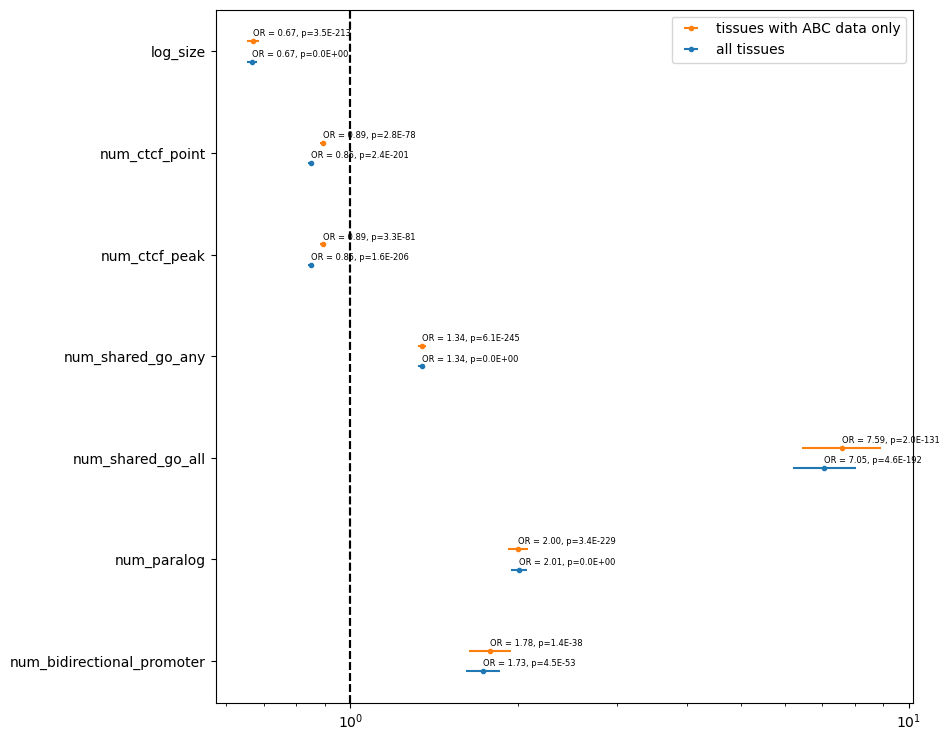

In [22]:
column_list = ['num_bidirectional_promoter',
       'num_paralog', 'num_shared_go_all', 'num_shared_go_any',
       'num_ctcf_peak', 'num_ctcf_point', 'log_size']
odds_ratios_no_enhancer = get_odds_df(tissue_combined_joined_df, column_list=column_list)

make_log_odds_plot_multiple([odds_ratios_no_enhancer, odds_ratios_enhancer], labels=['all tissues', 'tissues with ABC data only'])

num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.079873
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                39716
Model:                          Logit   Df Residuals:                    39714
Method:                           MLE   Df Model:                            1
Date:                Fri, 16 Aug 2024   Pseudo R-squ.:                0.002994
Time:                        11:39:09   Log-Likelihood:                -3172.2
converged:                       True   LL-Null:                       -3181.8
Covariance Type:            nonrobust   LLR p-value:                 1.270e-05
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -4.2028      0.043 

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                39353
Model:                          Logit   Df Residuals:                    39351
Method:                           MLE   Df Model:                            1
Date:                Fri, 16 Aug 2024   Pseudo R-squ.:                 0.01581
Time:                        11:39:15   Log-Likelihood:                -1509.8
converged:                       True   LL-Null:                       -1534.1
Covariance Type:            nonrobust   LLR p-value:                 3.295e-12
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -4.5439      0.088    -51.869      0.000      -4.716      -4.372
num_strong_enhancers    -0.4578      0.070     -6.530      0.000      -0.595      -0.320
num_paralog


<AxesSubplot: >

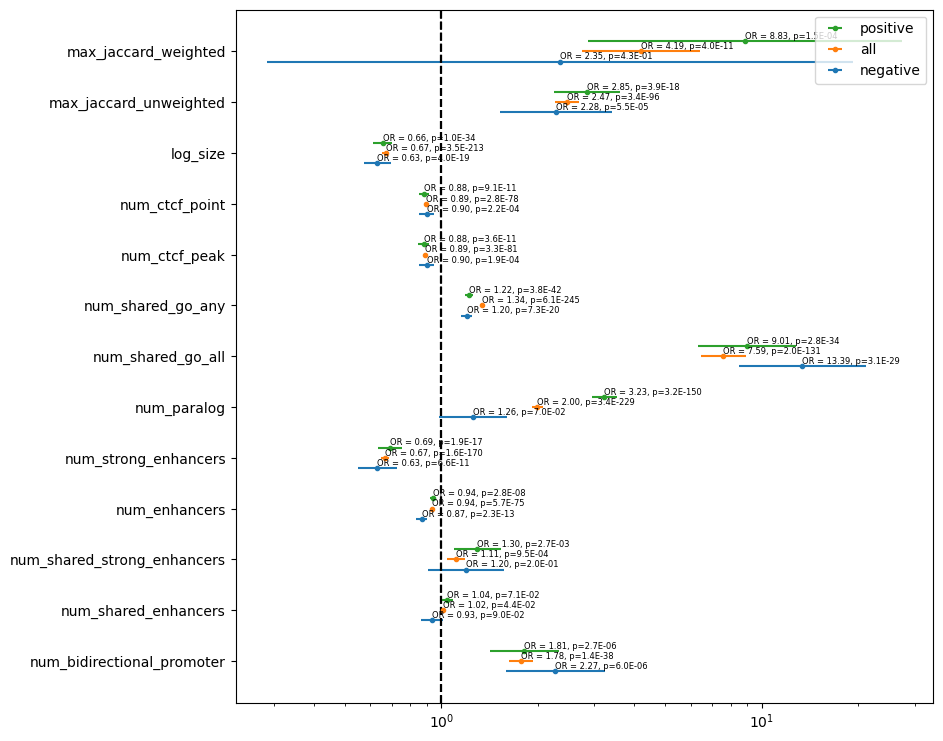

In [23]:
# positive negative plot combining over tissues
tissue_combined_enhancer_joined_df  = tissue_combined_enhancer_joined_df.reset_index()
combined_pos_df = tissue_combined_enhancer_joined_df[((tissue_combined_enhancer_joined_df['type']=='cluster')&(tissue_combined_enhancer_joined_df['has_high_pos_corr'])) | (tissue_combined_enhancer_joined_df['type']=='null')]
combined_neg_df = tissue_combined_enhancer_joined_df[((tissue_combined_enhancer_joined_df['type']=='cluster')&(tissue_combined_enhancer_joined_df['has_neg_corr'])) | (tissue_combined_enhancer_joined_df['type']=='null')]
odds_ratios_positive = get_odds_df(combined_pos_df)
odds_ratios_negative = get_odds_df(combined_neg_df)

make_log_odds_plot_multiple([odds_ratios_negative, odds_ratios_enhancer, odds_ratios_positive], labels=['negative', 'all', 'positive'])


num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.691841
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1234
Model:                          Logit   Df Residuals:                     1232
Method:                           MLE   Df Model:                            1
Date:                Thu, 15 Aug 2024   Pseudo R-squ.:                0.001885
Time:                        14:10:25   Log-Likelihood:                -853.73
converged:                       True   LL-Null:                       -855.34
Covariance Type:            nonrobust   LLR p-value:                   0.07253
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -0.0343      0.060 

<AxesSubplot: >

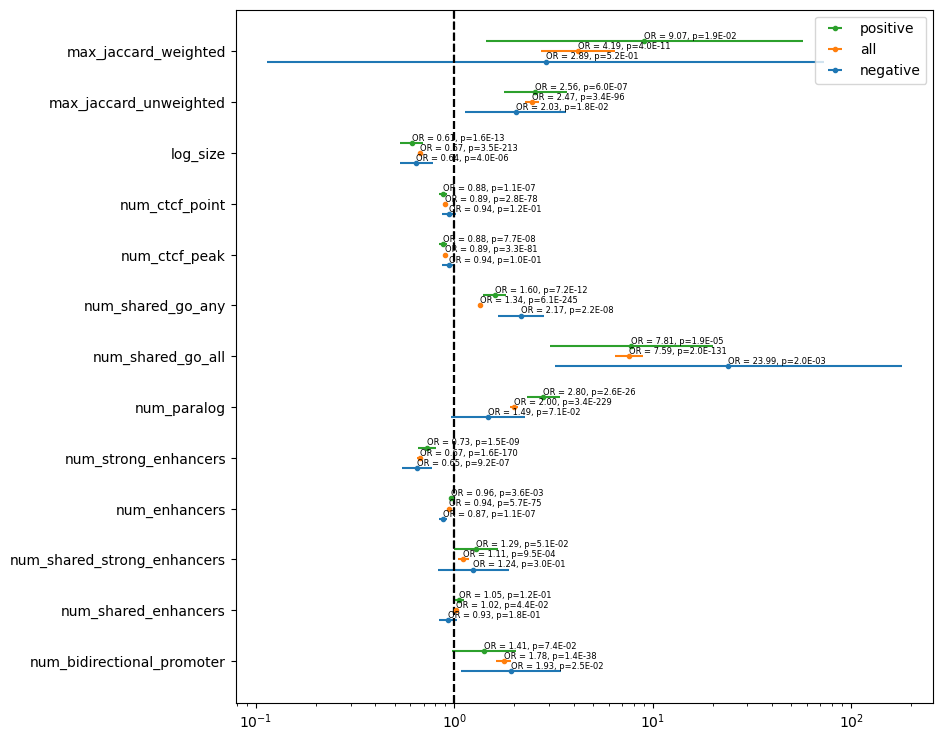

In [106]:
# balanced classes?
combined_pos_df = tissue_combined_enhancer_joined_df[((tissue_combined_enhancer_joined_df['type']=='cluster')&(tissue_combined_enhancer_joined_df['has_high_pos_corr']))]
combined_pos_df = pd.concat([combined_pos_df, tissue_combined_enhancer_joined_df[tissue_combined_enhancer_joined_df['type']=='null'].sample(len(combined_pos_df))])
combined_neg_df = tissue_combined_enhancer_joined_df[((tissue_combined_enhancer_joined_df['type']=='cluster')&(tissue_combined_enhancer_joined_df['has_neg_corr']))]
combined_neg_df = pd.concat([combined_neg_df, tissue_combined_enhancer_joined_df[tissue_combined_enhancer_joined_df['type']=='null'].sample(len(combined_neg_df))])

odds_ratios_positive = get_odds_df(combined_pos_df)
odds_ratios_negative = get_odds_df(combined_neg_df)

make_log_odds_plot_multiple([odds_ratios_negative, odds_ratios_enhancer, odds_ratios_positive], labels=['negative', 'all', 'positive'])


In [40]:
sns.hitplot(tissue_combined_enhancer_joined_df, x='max_jaccard_weighted')

AttributeError: module 'seaborn' has no attribute 'hitplot'

In [38]:
tissue_combined_enhancer_joined_df['max_jaccard_weighted_10'] = tissue_combined_enhancer_joined_df['max_jaccard_weighted'] * 10
tissue_combined_enhancer_joined_df['max_jaccard_weighted_100'] = tissue_combined_enhancer_joined_df['max_jaccard_weighted'] * 100

tissue_combined_enhancer_joined_df['max_jaccard_weighted_.1'] = tissue_combined_enhancer_joined_df['max_jaccard_weighted']/ 10
tissue_combined_enhancer_joined_df['max_jaccard_weighted_.01'] = tissue_combined_enhancer_joined_df['max_jaccard_weighted']/100

tissue_combined_enhancer_joined_df['max_jaccard_center_normed'] = tissue_combined_enhancer_joined_df['max_jaccard_weighted']

odds_ratios_jaccard_scaled = get_odds_df(tissue_combined_enhancer_joined_df, column_list=['max_jaccard_weighted_100','max_jaccard_weighted_10','max_jaccard_weighted', 'max_jaccard_weighted_.1', 'max_jaccard_weighted_.01'], 
filter_list=['max_jaccard_weighted_100','max_jaccard_weighted_10','max_jaccard_weighted', 'max_jaccard_weighted_.1', 'max_jaccard_weighted_.01'])


max_jaccard_weighted_100
Optimization terminated successfully.
         Current function value: 0.379346
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                41253
Model:                          Logit   Df Residuals:                    41251
Method:                           MLE   Df Model:                            1
Date:                Fri, 16 Aug 2024   Pseudo R-squ.:                0.001306
Time:                        11:45:32   Log-Likelihood:                -15649.
converged:                       True   LL-Null:                       -15670.
Covariance Type:            nonrobust   LLR p-value:                 1.567e-10
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.9831      0.017   -116.8

<AxesSubplot: xlabel='Log odds'>

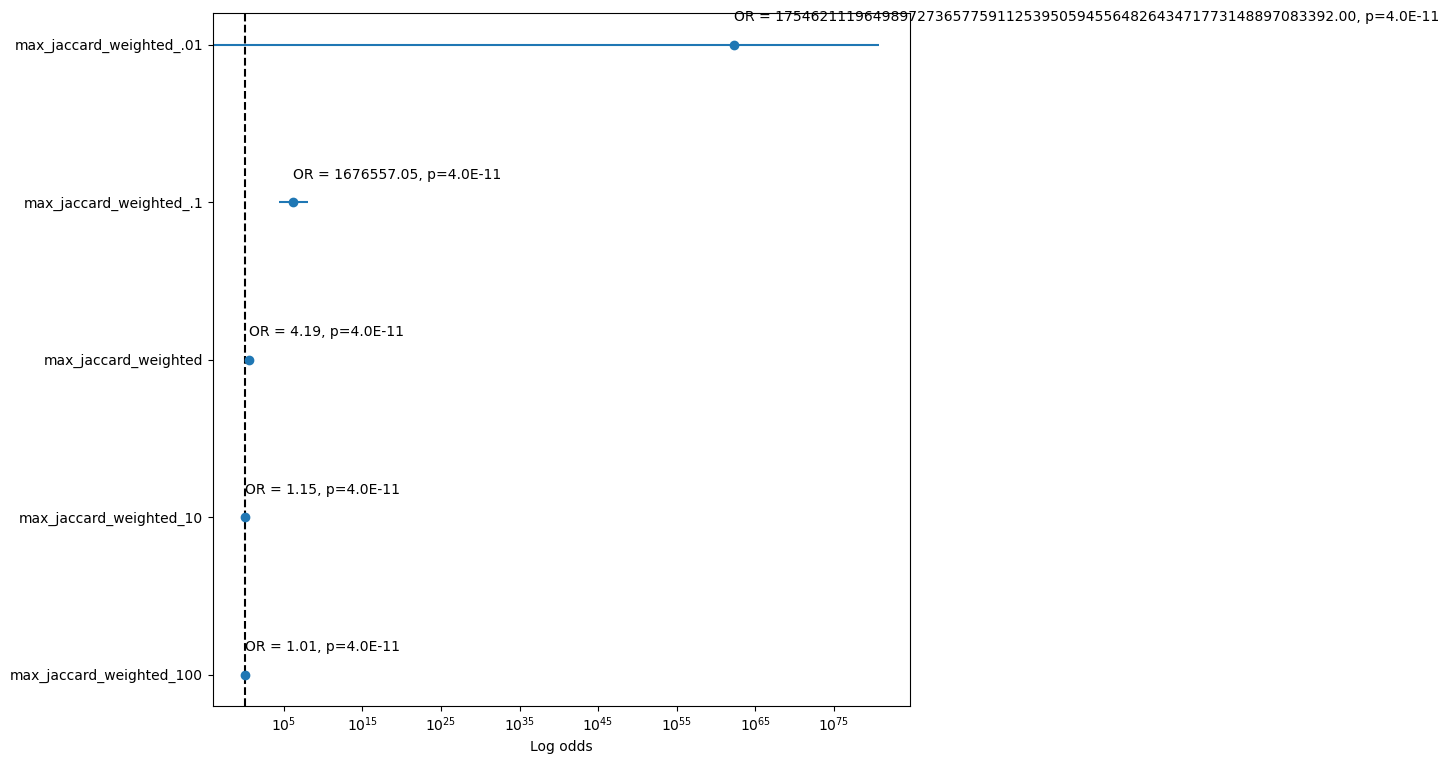

In [39]:
# maybe the large error bars on jaccard are due to the small jaccard values?
make_log_odds_plot(odds_ratios_jaccard_scaled)

In [ ]:
# positive vs negative with distance correction (resampled null?)

resamp_joined_df = pd.concat([cluster_df[(cluster_df['N_genes']==2)], distance_matched_null], keys=['cluster', 'null'], names=['type', 'idx'])
resamp_joined_df = resamp_joined_df[~resamp_joined_df['has_cross_map']]
odds_ratios_resamp = get_odds_df(resamp_joined_df, column_list=column_list)

# positive negative plot combining over tissues
tissue_combined_enhancer_joined_df  = tissue_combined_enhancer_joined_df.reset_index()
combined_pos_df = tissue_combined_enhancer_joined_df[((tissue_combined_enhancer_joined_df['type']=='cluster')&(tissue_combined_enhancer_joined_df['has_high_pos_corr'])) | (tissue_combined_enhancer_joined_df['type']=='null')]
combined_neg_df = tissue_combined_enhancer_joined_df[((tissue_combined_enhancer_joined_df['type']=='cluster')&(tissue_combined_enhancer_joined_df['has_neg_corr'])) | (tissue_combined_enhancer_joined_df['type']=='null')]
odds_ratios_positive = get_odds_df(combined_pos_df)
odds_ratios_negative = get_odds_df(combined_neg_df)

make_log_odds_plot_multiple([odds_ratios_negative, odds_ratios_enhancer, odds_ratios_positive], labels=['negative', 'all', 'positive'])

